In [1]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_zarr('/swot/SUM02/spencer/for_qiyu/Raw_eul_lag_surf_vels.zarr')

unfiltered_eta_ds = xr.open_zarr('/swot/SUM02/spencer/daily_filt/unfiltered_eta_nom.zarr')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr')

filtered_eta_ds = xr.open_zarr('/swot/SUM02/spencer/daily_filt/filtered_eta_nom.zarr')

unfiltered_eta = unfiltered_eta_ds.eta+eta_mean.Eta
filtered_eta = filtered_eta_ds.eta+eta_mean.Eta

In [6]:
ds

<xarray.Dataset>
Dimensions:        (i: 2160, i_g: 2160, j: 2160, j_g: 2160, time: 70)
Coordinates: (12/20)
    DXC            (j, i_g) float32 dask.array<chunksize=(180, 2160), meta=np.ndarray>
    DXG            (j_g, i) float32 dask.array<chunksize=(2160, 180), meta=np.ndarray>
    DYC            (j_g, i) float32 dask.array<chunksize=(2160, 180), meta=np.ndarray>
    DYG            (j, i_g) float32 dask.array<chunksize=(180, 2160), meta=np.ndarray>
    RAC            (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
    XC             (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
    ...             ...
  * time           (time) int64 0 86400 172800 ... 5788800 5875200 5961600
    x              (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
    x0             (i) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    y              (j, i) float32 dask.array<chunksize=(180, 180), meta=np.ndarray>
    y0             (j) float64 dask.array<chunksize=(180,), meta=np.ndarray>
    z0             float64 ...
Dimensions without coordinates: i_g, j_g
Data variables:
    eulfiltered_u  (time, j, i) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    eulfiltered_v  (time, j, i) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    lagfiltered_u  (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    lagfiltered_v  (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    unfiltered_u   (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    unfiltered_v   (time, i, j) float64 dask.array<chunksize=(1, 180, 180), meta=np.ndarray>

In [3]:
grid = Grid(ds, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [4]:

f = 2*2*np.pi/24/3600*np.sin(ds.YC.values*np.pi/180)
f_array = (xr.DataArray(f,dims=['j','i']).assign_coords(i=unfiltered_eta.i,j=unfiltered_eta.j))

In [5]:
g=9.81

u_g = (-g/f*grid.interp(grid.diff(unfiltered_eta,'Y'),'Y')/ds.DYG).isel(time=slice(1,2000))
v_g = (g/f*grid.interp(grid.diff(unfiltered_eta,'X'),'X')/ds.DXG).isel(time=slice(1,2000))

ufilt_g = (-g/f*grid.interp(grid.diff(filtered_eta,'Y'),'Y')/ds.DYG).isel(time=slice(1,2000))
vfilt_g = (g/f*grid.interp(grid.diff(filtered_eta,'X'),'X')/ds.DXG).isel(time=slice(1,2000))

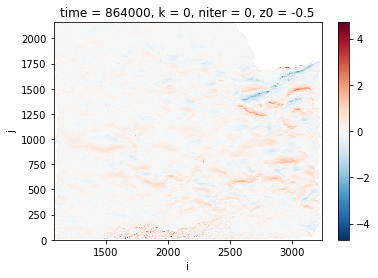

In [14]:
u_g.isel(time=10).plot(x='i')

In [20]:
last_time = 70
unfiltered_speed = (ds.unfiltered_u.isel(time=slice(0,last_time))**2 
                    + ds.unfiltered_v.isel(time=slice(0,last_time))**2)**0.5

filtered_speed = (ds.lagfiltered_u.isel(time=slice(0,last_time))**2 
                    + ds.lagfiltered_v.isel(time=slice(0,last_time))**2)**0.5

eulfiltered_speed = (ds.eulfiltered_u.isel(time=slice(0,last_time))**2 
                    + ds.eulfiltered_v.isel(time=slice(0,last_time))**2)**0.5

geostrophic_speed = (u_g.isel(time=slice(0,last_time))**2 
                    + v_g.isel(time=slice(0,last_time))**2)**0.5

unfiltered_minus_g = unfiltered_speed - geostrophic_speed

lagfiltered_minus_g = filtered_speed - geostrophic_speed

eulfiltered_minus_g = eulfiltered_speed - geostrophic_speed

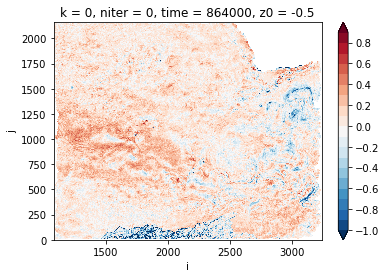

In [19]:
unfiltered_minus_g.isel(time=10).plot(x='i',levels=np.arange(-1,1,0.1))
plt.add_patch( Rectangle((850, 920),
                        460, 2,
                        fc ='none', 
                        ec ='g',
                        lw = 10) )

In [34]:
2160-920*2

320

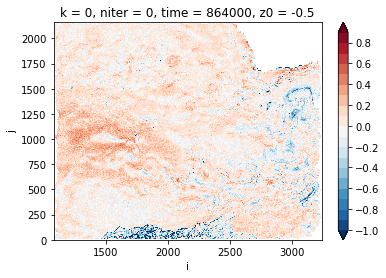

In [21]:
lagfiltered_minus_g.isel(time=10).plot(x='i',levels=np.arange(-1,1,0.1))

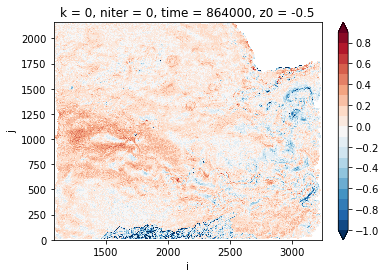

In [22]:
eulfiltered_minus_g.isel(time=10).plot(x='i',levels=np.arange(-1,1,0.1))

In [26]:
last_time = 70
rms_unfiltered = ((((unfiltered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()

rms_filtered = ((((filtered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()

rms_eulfiltered = ((((eulfiltered_speed.isel(time=slice(0,last_time)) -
            geostrophic_speed.isel(time=slice(0,last_time)))**2).mean('time'))**0.5).load()


/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


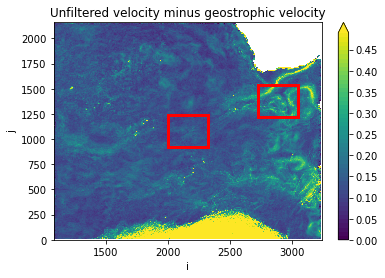

In [69]:
rms_unfiltered.plot(x='i',levels=np.arange(0,0.5,0.01))

ax=plt.gca()
ax.add_patch( Rectangle((920+1080, 920),
                        320, 320,
                        fc ='none', 
                        ec ='r',
                        lw = 3) )

ax=plt.gca()
ax.add_patch( Rectangle((1650+1080, 1220),
                        320, 320,
                        fc ='none', 
                        ec ='r',
                        lw = 3) )

plt.title('Unfiltered velocity minus geostrophic velocity')

fig=plt.gcf()
plt.savefig('region_positions.png')

In [8]:
ds.XC[920,920].values

array(3.6770835, dtype=float32)

In [9]:
ds.YC[920,920].values

array(-45.730984, dtype=float32)

In [11]:
(ds.XC[920,920+320]-ds.XC[920,920]).values

array(6.6666675, dtype=float32)

In [12]:
(ds.YC[920+320,850]-ds.YC[920,850]).values

array(4.4977264, dtype=float32)

In [59]:
ds.DYG[920:920+320,850].sum().values

array(499992.44, dtype=float32)

In [65]:
ds.DXG[1000,920:920+320].sum().values

array(527359.5, dtype=float32)

In [67]:
920+920+320

2160